https://www.kaggle.com/competitions/kkbox-music-recommendation-challenge/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

In [2]:
from surprise import SVD

In [3]:
from scipy.sparse import csr_matrix, csc_matrix

In [4]:
from sklearn import metrics

In [5]:
train_df = pd.read_parquet("data_p1/train_p1.parquet")

In [6]:
n_train = train_df.shape[0]
n_train

7377418

In [7]:
test_df = pd.read_parquet("data_p1/test_p1.parquet")

In [8]:
n_test = test_df.shape[0]
n_test

2556790

In [9]:
member_df = pd.read_parquet("data_p1/members_p1.parquet")

In [10]:
n_member = member_df.shape[0]

In [11]:
member_df.dtypes

city                       int64
bd                         int64
gender                    object
registered_via             int64
registration_init_time     int64
expiration_date            int64
userID                     int32
in_traindata                bool
dtype: object

In [12]:
song_df = pd.read_parquet("data_p1/songs_p1.parquet")

In [13]:
n_song = song_df.shape[0]
n_song

419781

In [14]:
train_df.head()

,source_system_tab,source_screen_name,source_type,rating,userID,song_idx,itemID,time,time_first,time_old
0,explore,Explore,online-playlist,1,21893,1391177,335731,0,0,0
1,my library,Local playlist more,local-playlist,1,26052,1584026,357849,1,1,0
2,my library,Local playlist more,local-playlist,1,26052,456722,210391,2,2,0
3,my library,Local playlist more,local-playlist,1,26052,1072225,308876,3,3,0
4,explore,Explore,online-playlist,1,21893,518476,222980,4,4,0


In [15]:
filter1 = train_df["source_system_tab"].isna()
train_df.loc[filter1,"source_system_tab"] = "None"

filter1 = test_df["source_system_tab"].isna()
test_df.loc[filter1,"source_system_tab"] = "None"

array([<AxesSubplot:title={'center':'count'}, xlabel='source_system_tab'>,
       <AxesSubplot:title={'center':'mean'}, xlabel='source_system_tab'>],
      dtype=object)

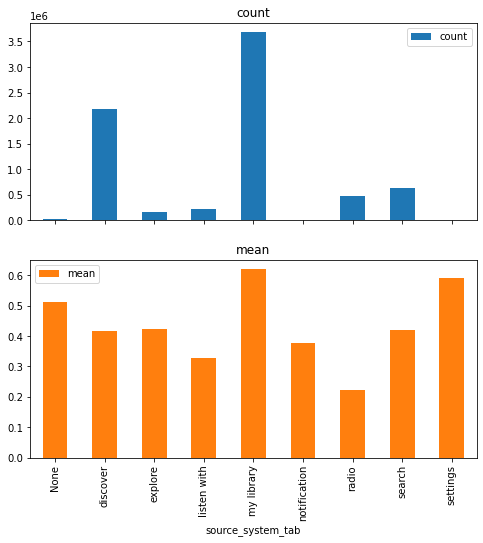

In [16]:
train_df[["source_system_tab", "rating"]].groupby("source_system_tab").agg(["count", "mean"])["rating"].plot.bar(subplots = True, figsize = (8, 8))

array([<AxesSubplot:title={'center':'count'}, xlabel='source_system_tab'>],
      dtype=object)

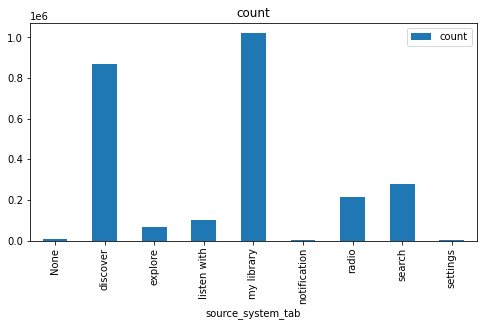

In [17]:
test_df[["source_system_tab", "itemID"]].groupby("source_system_tab").agg(["count"])["itemID"].plot.bar(subplots = True, figsize = (8, 4))

In [18]:
train_df["source_system_tab"].isna().sum()

0

In [19]:
train_df["source_system_tab"].unique()

array(['explore', 'my library', 'search', 'discover', 'None', 'radio',
       'listen with', 'notification', 'settings'], dtype=object)

In [20]:
g0_set = set(["my library", "settings"])
g1_set = set(["discover", "explore", "search"])
g2_set = set(["listen with", "notification"])
g3_set = set(["radio"])


In [21]:
def source_id(source):
    
    if source in g0_set:
        return 0
    
    if source in g1_set:
        return 1
    
    if source in g2_set:
        return 2
    
    if source in g3_set:
        return 3
    
    return 4
    

In [22]:
train_df["source_id"] = train_df["source_system_tab"].apply(lambda x: source_id(x))

In [23]:
test_df["source_id"] = test_df["source_system_tab"].apply(lambda x: source_id(x))

In [24]:
train_df[["source_system_tab", "source_id"]].groupby("source_system_tab").max()

,source_id
source_system_tab,
None,4
discover,1
explore,1
listen with,2
my library,0
notification,2
radio,3
search,1
settings,0


In [25]:
def stat_data(n_val, tag, cutoff):

    n_train = train_df.shape[0]
    
    n_train2 = n_train - n_val
    
    sum_df = train_df[[tag, "rating"]].iloc[:n_train2,:].groupby(tag).sum()
    member_count = train_df[[tag, "rating"]].iloc[:n_train2,:].groupby(tag).count()
    
    member_p = sum_df/(0.5+member_count)
    
    member_p = member_p.reset_index()
    
    member_count = member_count.reset_index()
    

    sum_df = train_df[[tag, "source_id", "rating"]].iloc[:n_train2,:].groupby([tag, "source_id"]).sum()
    member_source_count = train_df[[tag,"source_id" ,"rating"]].iloc[:n_train2,:].groupby([tag, "source_id"]).count()
    
    member_source_p = sum_df/(0.5+member_source_count)
    
    
    member_source_p =  member_source_p.reset_index()
    
    member_source_count = member_source_count.reset_index()
    
    #return member_count_df, count_df,  member_p, member_source_p

    
    member_p_dic = {}
    m_array =  member_p[tag].to_numpy()
    p_array =  member_p["rating"].to_numpy()
    c_array = member_count["rating"].to_numpy()
    for i in range(m_array.shape[0]):
        if c_array[i] > cutoff:
            member_p_dic[m_array[i]] = p_array[i]


    member_source_p_dic = {}
    m_array =  member_source_p[tag].to_numpy()
    p_array =  member_source_p["rating"].to_numpy()
    c_array = member_source_count["rating"].to_numpy()
    s_array = member_source_p["source_id"].to_numpy()
    for i in range(m_array.shape[0]):
        if c_array[i] > cutoff:
            member_source_p_dic[(m_array[i], s_array[i])] = p_array[i]

            
            
    filter1 = member_source_count["rating"] > cutoff
    
    
    return member_p_dic, member_source_p_dic, set(member_source_count.loc[filter1][tag].unique())


In [26]:
def source_stat(n_val):
    
    n_train = train_df.shape[0]
    
    n_train2 = n_train - n_val
    
    
    mean_df = train_df[["source_id", "rating"]].iloc[:n_train2,:].groupby("source_id").mean()
    
    mean_df = mean_df.reset_index()
    
    m_array = mean_df["source_id"].to_numpy()
    val_array = mean_df["rating"].to_numpy()
    
    p_dic = {}
    for i in range(m_array.shape[0]):
        p_dic[m_array[i]] = val_array[i]
        
    return p_dic
    

In [27]:
train_df.head()

,source_system_tab,source_screen_name,source_type,rating,userID,song_idx,itemID,time,time_first,time_old,source_id
0,explore,Explore,online-playlist,1,21893,1391177,335731,0,0,0,1
1,my library,Local playlist more,local-playlist,1,26052,1584026,357849,1,1,0,0
2,my library,Local playlist more,local-playlist,1,26052,456722,210391,2,2,0,0
3,my library,Local playlist more,local-playlist,1,26052,1072225,308876,3,3,0,0
4,explore,Explore,online-playlist,1,21893,518476,222980,4,4,0,1


In [28]:
def filter_df(n_start, n_val, min_member, min_song):
    
    n_train = train_df.shape[0]
    
    n_train2 = n_train - n_val
    
    train_df2 = train_df.iloc[n_start:n_train2,:]
    
    query1 =  "rating >" + str(min_member)
    query2 =  "rating >" + str(min_song)
    
    
    
    member_list = train_df2[["userID", "rating"]].groupby("userID").count().query(query1).reset_index()["userID"].to_numpy()
    song_list = train_df2[["itemID", "rating"]].query("itemID >= 0").groupby("itemID").count().query(query2).reset_index()["itemID"].to_numpy()
    
    member_set = set(member_list)
    song_set = set(song_list)

    
    filter1 = (train_df2["userID"].apply(lambda x: x in member_set)) & (train_df2["itemID"].apply(lambda x: x in song_set)) 

    
    train_df3 = train_df2[["userID", "itemID", "source_id", "rating"]].loc[filter1]
    
    print(len(member_set),"members, ",  len(song_set), "songs")
    
    return train_df3
    
    
    

### Set validation size

In [29]:
n_val = int(n_train*0.2)
n_val = 0


In [30]:
#n_start = int(n_train*0.2)
n_start = 0

In [31]:
#member_count, member_source_count, member_p, member_source_p = member_stat(n_val)

In [32]:
member_p_dic, member_source_p_dic, member_set =  stat_data(n_val, "userID", 20)

In [33]:
song_p_dic, song_source_p_dic, song_set =  stat_data(n_val, "itemID", 20)

In [34]:
source_p_dic = source_stat(n_val)

In [35]:
tmp_df = filter_df(n_start, n_val, 20, 20)
#tmp_df = filter_df(n_val, 100, 400)
#tmp_df = filter_df(n_val, 20, 200)

27764 members,  89620 songs


In [36]:
import os

from surprise import Dataset, NormalPredictor, Reader
from surprise.model_selection import cross_validate
from surprise import accuracy, Dataset, SVD, SVDpp

In [37]:
reader = Reader(rating_scale=(0, 1))

In [38]:
data_sp = []
for source in range(5):
    filter1 = tmp_df["source_id"] == source
    data_sp.append(Dataset.load_from_df(tmp_df[["userID", "itemID", "rating"]].loc[filter1,:], reader).build_full_trainset())

In [39]:
model_sp = []
for i in range(5):
    print("train svd for source", i)
    
    algo = SVD(n_factors = 25, n_epochs = 40)
    algo.fit(data_sp[i])
    model_sp.append(algo)

train svd for source 0
train svd for source 1
train svd for source 2
train svd for source 3
train svd for source 4


In [40]:
user_set = set(tmp_df["userID"].to_numpy())
item_set = set(tmp_df["itemID"].to_numpy())

In [43]:
def idx_dic(val, dic):
    try:
        return dic[val]
    except KeyError:
        return -1
    
v_idx_dic = np.vectorize(idx_dic)

## Validate

In [97]:
song_val = train_df["itemID"].iloc[-n_val:].to_numpy()
member_val =  train_df["userID"].iloc[-n_val:].to_numpy()
y_val = train_df["rating"].iloc[-n_val:].to_numpy()
source_val =  train_df["source_id"].iloc[-n_val:].to_numpy()

#song_val_idx = v_idx_dic(song_val, s_idx_dic)
#member_val_idx =  v_idx_dic(member_val, m_idx_dic)

In [98]:
yhat_val = np.zeros(n_val)

In [99]:
for i in range(n_val):
    yhat_val[i] = source_p_dic[source_val[i]]

In [100]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val, pos_label=1)
metrics.auc(fpr, tpr)

0.5820893244413426

In [101]:
#for i in range(n_val):
#    try:
#        yhat_val[i] = member_p_dic[member_val[i]]
#    except KeyError:
#        pass

#fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val, pos_label=1)
#metrics.auc(fpr, tpr)

0.6087654705570389 (user_mean)

In [102]:
for i in range(n_val):
    try:
        yhat_val[i] = song_source_p_dic[(song_val[i], source_val[i])]
    except KeyError:
        pass

In [103]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val, pos_label=1)
metrics.auc(fpr, tpr)

0.6170482654672829

In [104]:
for i in range(n_val):
    try:
        yhat_val[i] = member_source_p_dic[(member_val[i], source_val[i])]
    except KeyError:
        pass

In [105]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val, pos_label=1)
metrics.auc(fpr, tpr)

0.6451557798439718

In [106]:
n_val

1475483

In [107]:
count = 0
for i in range(n_val):
    user = member_val[i]
    item = song_val[i]
    source = source_val[i]
    
    if (item in item_set) and (user in user_set):
        count += 1
        yhat_val[i] = model_sp[source].predict(user, item, verbose=False).est


In [109]:
count/n_val

0.6876744767645577

In [108]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val, pos_label=1)
metrics.auc(fpr, tpr)

0.6641073245202727

SVD (val 0.2) n_epochs = 20
* 0.661722705849648: n_factor = 100
* 0.6631268974024442: n_factor = 40
* 0.6634261792303882: n_factor = 30
* 0.6635273380985012: n_factor = 25
* 0.6635223695003534: n_factor = 15


n_factor = 25:

* 0.6876744767645577: n_epochs = 40

## Test

In [41]:
song_test = test_df["itemID"].to_numpy()
member_test =  test_df["userID"].to_numpy()
source_test =  test_df["source_id"].to_numpy()

#song_test_idx = v_idx_dic(song_test, s_idx_dic)
#member_test_idx =  v_idx_dic(member_test, m_idx_dic)

kaggle private score: 0.62125 (song_source_stat.csv)

In [42]:
yhat_test = np.zeros(n_test)
yhat_test[:] = np.nan

In [43]:
for i in range(n_test):
    yhat_test[i] = source_p_dic[source_test[i]]

In [44]:
count1 = 0
for i in range(n_test):
    try:
        yhat_test[i] = song_source_p_dic[(song_test[i], source_test[i])]
        count1 += 1
    except KeyError:
        pass

In [45]:
count1/n_test

0.6412845794922539

In [46]:
#sample_df = pd.read_parquet("data/sample_submission.parquet")
#sample_df["target"] = yhat_test
#sample_df.to_csv("output/song_source_stat.csv", index = False)

kaggle private score: 0.65077 (simple_stat.csv)

In [47]:
count2 = 0
for i in range(n_test):
    try:
        yhat_test[i] = member_source_p_dic[(member_test[i], source_test[i])]
        count2 += 1
    except KeyError:
        pass

In [48]:
count2/n_test

0.8499825953637178

In [49]:
np.isnan(yhat_test).sum()


0

In [50]:
#sample_df = pd.read_parquet("data/sample_submission.parquet")
#sample_df["target"] = yhat_test
#sample_df.to_csv("output/user_source_stat.csv", index = False)

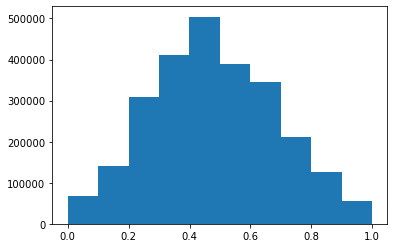

In [51]:
plt.hist(yhat_test)
plt.show()

**Surprise SVD**

In [52]:
count = 0
for i in range(n_test):
    user = member_test[i]
    item = song_test[i]
    source = source_test[i]
    
    if (item in item_set) and (user in user_set):
        count += 1
        yhat_test[i] = model_sp[source].predict(user, item, verbose=False).est


In [53]:
count/n_test

0.7474082736556386

In [54]:
np.isnan(yhat_test).sum(), np.max(yhat_test), np.min(yhat_test)

(0, 1.0, 0.0)

In [55]:
yhat_test[yhat_test > 1] = 1
yhat_test[yhat_test < 0] = 0

In [56]:
sample_df = pd.read_parquet("data/sample_submission.parquet")
sample_df["target"] = yhat_test
sample_df.to_csv("output/surprise_svd_25_40_3.csv", index = False)

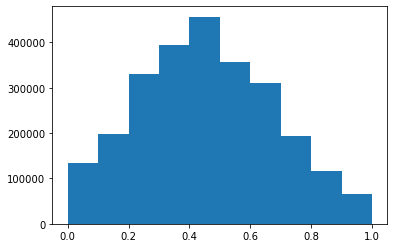

In [57]:
plt.hist(yhat_test)
plt.show()

kaggle private score: 0.65557 (collab_3.csv)

In [67]:
yhat_test = pred_y_collaborative(sim_mat, score_mat, rated_mat, song_test, member_test, source_test, \
                        m_idx_dic, s_idx_dic, member_source_p_dic, yhat_test, 20)

1052713


In [68]:
1052713/n_test

0.4117322893159

In [69]:
yhat_test[yhat_test > 1] = 1
yhat_test[yhat_test < 0] = 0

In [70]:
sample_df = pd.read_parquet("data/sample_submission.parquet")
sample_df["target"] = yhat_test
sample_df.to_csv("output/surprise_1.csv", index = False)

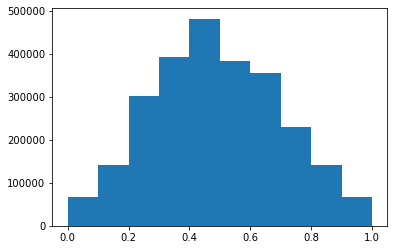

In [71]:
plt.hist(yhat_test)
plt.show()

**Running Update**

In [51]:
yhat_test = pred_y_collaborative(sim_mat, score_mat, rated_mat, song_test, member_test, source_test, \
                        m_idx_dic, s_idx_dic, member_source_p_dic, yhat_test, 20, True)

927406


In [52]:
np.min(yhat_test), np.max(yhat_test)

(0.0, 1.0)

In [53]:
yhat_test[yhat_test > 1] = 1
yhat_test[yhat_test < 0] = 0

In [54]:
sample_df = pd.read_parquet("data/sample_submission.parquet")
sample_df["target"] = yhat_test
sample_df.to_csv("output/collab_RunningUpdate.csv", index = False)

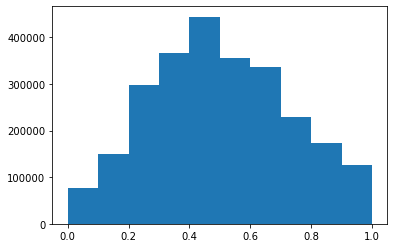

In [77]:
plt.hist(yhat_test)
plt.show()

In [59]:
np.max(yhat_test), np.min(yhat_test)

(0.999637943519189, 0.0)

In [48]:
## SVD

In [49]:
yhat_test = pred_y_svd(Rec_mat, song_test, member_test, source_test, \
                        m_idx_dic, s_idx_dic, member_source_p_dic, yhat_test)

In [50]:
np.max(yhat_test), np.min(yhat_test)

(1.6514006541097297, -0.5781423609600644)

In [51]:
yhat_test[yhat_test > 1] = 1
yhat_test[yhat_test < 0] = 0

In [53]:
sample_df = pd.read_parquet("data/sample_submission.parquet")
sample_df["target"] = yhat_test
sample_df.to_csv("output/svd_1.csv", index = False)

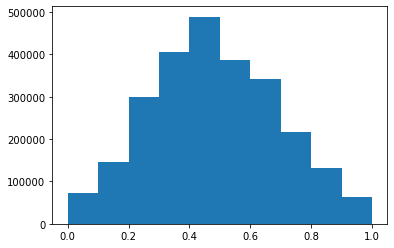

In [52]:
plt.hist(yhat_test)
plt.show()

In [45]:
yhat_test =  pred_y_collaborative(sim_mat, score_mat, rated_mat, song_test_idx, member_test_idx, source_test, yhat_test, 20)

In [46]:
np.isnan(yhat_test).sum()

0

In [47]:
yhat_test[yhat_test > 1] = 1
yhat_test[yhat_test < 0] = 0

In [48]:
sample_df = pd.read_parquet("data/sample_submission.parquet")
sample_df["target"] = yhat_test
sample_df.to_csv("output/collab_sim.csv", index = False)

(array([ 49258.,  38898., 306215., 124906., 810238., 235741., 635458.,
         89274., 123503., 143299.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

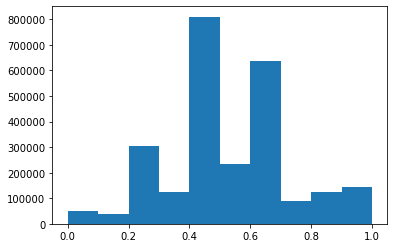

In [50]:
plt.hist(yhat_test)

In [283]:
i = 9
song = song_val_idx[i]
member = member_val_idx[i]
source = source_val[i]

print(song, member, source)

if (song >= 0) and (member >= 0):

    #sim in source
    rated_by_member = rated_mat[member,:, source] == 1

    top_N = np.argsort(sim_mat[song,:, source]*rated_by_member)[-10:]
    y_N = score_mat[member, top_N, source]
    
    yhat


1729 7685 1


In [284]:
sim_mat[song, top_N, source]

array([0.04957835, 0.05072257, 0.0513436 , 0.05397083, 0.05474776,
       0.05958869, 0.06377444, 0.06512461, 0.07342931, 0.09181191])

In [285]:
top_N

array([ 290,  617,   58,  451,  465,   63,  651,  266, 1352,  897],
      dtype=int64)

In [286]:
(score_mat[member, top_N, source])


array([-1., -1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.])

In [221]:
y_N = score_mat[member, top_N, source]

In [222]:
y_N

array([-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [21]:
member_set = set(member_list)

In [19]:
song_set = set(song_list)
n_song2 = len(song_set)
n_song2/n_song

0.0004668338907469342

In [22]:
filter1 = train_df["song_idx"].apply(lambda x: x in song_set) & train_df["msno_idx"].apply(lambda x: x in member_set)

In [23]:
collab_df = train_df[["song_idx", "msno_idx", "target"]].loc[filter1].pivot_table(index = "msno_idx", columns = ["song_idx"])


In [24]:
member_list = np.array(collab_df.index)

In [25]:
member_set = set(member_list)
len(member_set)

10270

In [26]:
song_list = np.array(collab_df["target"].columns)

In [27]:
song_set = set(song_list)
n_song2 = len(song_set)
n_song2

1072

In [28]:
member_idx_dic = {}
for i in range(member_list.shape[0]):
    member_idx_dic[member_list[i]] = i
    
    
song_idx_dic = {}
for i in range(song_list.shape[0]):
    song_idx_dic[song_list[i]] = i

In [29]:
collab_mat = (collab_df > 0.5).to_numpy()

In [30]:
vote_mat = np.isnan(collab_df).to_numpy()

In [31]:
vote_mat = ~vote_mat

In [32]:
vote_mat.shape

(10270, 1072)

In [33]:
collab_mat.shape

(10270, 1072)

In [34]:
collab_mat

array([[False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [35]:
collab_mat_csr = csr_matrix(collab_mat.T.astype(int))

In [36]:
collab_mat.shape

(10270, 1072)

In [37]:
collab_matT = collab_mat.T 

In [38]:
dot_mat = collab_mat_csr.dot(collab_mat_csr.T)

In [39]:
dot_mat = dot_mat.toarray()

In [40]:
abs_array = np.sum(collab_mat, axis = 0)

In [41]:
abs_array.reshape(-1,1)

array([[1348],
       [ 952],
       [ 627],
       ...,
       [ 703],
       [ 483],
       [ 315]])

In [42]:
abs_mat = np.matmul(abs_array.reshape(-1,1), abs_array.reshape(1,-1))

In [43]:
abs_mat

array([[1817104, 1283296,  845196, ...,  947644,  651084,  424620],
       [1283296,  906304,  596904, ...,  669256,  459816,  299880],
       [ 845196,  596904,  393129, ...,  440781,  302841,  197505],
       ...,
       [ 947644,  669256,  440781, ...,  494209,  339549,  221445],
       [ 651084,  459816,  302841, ...,  339549,  233289,  152145],
       [ 424620,  299880,  197505, ...,  221445,  152145,   99225]])

In [44]:
sim_mat = np.zeros((n_song2, n_song2))

In [45]:
sim_mat = np.zeros((n_song2, n_song2))

In [46]:
for i in range(n_song2):
    for j in range(n_song2):
        sim_mat[i,j] = dot_mat[i,j]/abs_mat[i,j]

In [50]:
sim_mat


array([[7.41839763e-04, 9.35092138e-05, 1.24231539e-04, ...,
        1.16077346e-04, 1.16728410e-04, 1.08332156e-04],
       [9.35092138e-05, 1.05042017e-03, 1.59154571e-04, ...,
        1.15053134e-04, 1.13088714e-04, 1.50060024e-04],
       [1.24231539e-04, 1.59154571e-04, 1.59489633e-03, ...,
        3.85679056e-04, 5.44840362e-04, 9.31621984e-04],
       ...,
       [1.16077346e-04, 1.15053134e-04, 3.85679056e-04, ...,
        1.42247511e-03, 3.38684549e-04, 4.29000429e-04],
       [1.16728410e-04, 1.13088714e-04, 5.44840362e-04, ...,
        3.38684549e-04, 2.07039337e-03, 6.63840415e-04],
       [1.08332156e-04, 1.50060024e-04, 9.31621984e-04, ...,
        4.29000429e-04, 6.63840415e-04, 3.17460317e-03]])

In [33]:
for i in range(n_song2):
    
    or_array = np.sum(collab_matT[i,:] + collab_matT[:], axis = 1)
    filter1 = or_array > 0
    sim_mat[i,filter1] = dot_mat[i,filter1]/or_array[filter1]
    
    if i % 300 == 0:
        print(i)
        

0
300
600
900


In [38]:
n_song2

1072

In [51]:
#from scipy.spatial.distance import pdist, squareform

In [ ]:
#jaccard_distances = pdist(collab_mat.T, metric='jaccard')

In [ ]:
#jaccard_distances = squareform(jaccard_distances)
#jaccard_similarity = 1-jaccard_distances

In [37]:
for i in range(n_song2):
    sim_mat[i,i] = 0

In [45]:
np.argsort(sim_mat[17,:])[0:20]


array([ 17, 987, 717, 675, 644, 456, 303, 488,  70, 187, 590,  22, 248,
       130, 166,  66, 583, 929,  38, 448], dtype=int64)

In [47]:
sim_mat.shape

(1072, 1072)

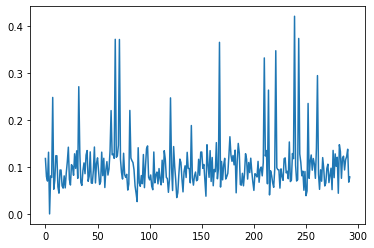

In [56]:
plt.plot(sim_mat[15,vote_mat[101,:]])

In [138]:
np.argsort(np.array([1,3,2,5,4]))


array([0, 2, 1, 4, 3], dtype=int64)

In [128]:
np.argsort(sim_mat[15,vote_mat[101,:]])[0:20]

array([  4,  88, 126, 154, 250, 215, 281,  87,  13, 183, 127, 118, 132,
       251, 122, 200, 248,  79, 103, 275], dtype=int64)

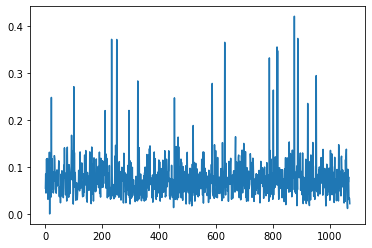

In [57]:
plt.plot(sim_mat[15,:])

In [140]:
top_N = np.argsort(sim_mat[1, vote_mat[10,:]])[-20:]

In [141]:
sim_mat[1, vote_mat[10,:]][top_N]

array([0.11123318, 0.11144661, 0.11196229, 0.11207779, 0.11320337,
       0.11337868, 0.11403509, 0.1150085 , 0.11529412, 0.11769834,
       0.1177274 , 0.1178653 , 0.11927711, 0.12350098, 0.12809917,
       0.12845941, 0.12912259, 0.13141946, 0.14613181, 0.22459222])

In [239]:
def predict_y(member, song):
    
    member_idx = member_idx_dic[member]
    song_idx = song_idx_dic[song]
    

    top_N = np.argsort(sim_mat[song_idx, vote_mat[member_idx,:]])[-30:]
    
    divider = np.sum(vote_mat[member_idx,:])
    
    if divider == 0:
        return np.nan
    
    sim_val = sim_mat[song_idx, vote_mat[member_idx,:]][top_N]
    record_val = collab_mat[member_idx,vote_mat[member_idx,:]][top_N]
    
    val = np.dot(sim_val, record_val)
    val2 = np.sum(sim_val)
    
    return val/val2
    

    

In [223]:
collab_mat.shape, sim_mat.shape

((10270, 1072), (1072, 1072))

In [224]:
msno_test = test_df["msno_idx"].to_numpy()
song_test = test_df["song_idx"].to_numpy()

In [232]:
n_test

2556790

In [240]:
yhat_test = np.zeros(n_test)
yhat_test[:] = np.nan

In [241]:
count = 0
for i in range(n_test):
    if (msno_test[i] in member_set) and (song_test[i] in song_set):
        count += 1
        yhat_test[i] = predict_y(msno_test[i], song_test[i])
        
        

In [242]:
count/n_test

0.15479722620942665

In [243]:
np.nanmean(yhat_test)

0.6447327626269546

(array([ 1814.,  6814., 16492., 29820., 45239., 57188., 66003., 67577.,
        59796., 45041.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

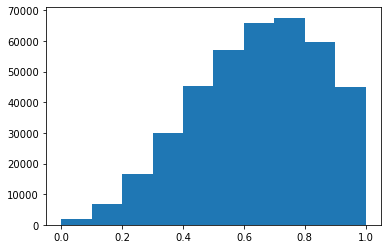

In [244]:
plt.hist(yhat_test)

In [245]:
content_df = pd.read_csv("output/svd_25.csv")

In [246]:
content_yhat = content_df["target"].to_numpy(copy = True)

In [247]:
filter1 = np.isnan(yhat_test)

In [248]:
yhat_test[filter1] = content_yhat[filter1]

In [255]:
np.sum(np.isnan(yhat_test)), yhat_test.shape

(0, (2556790,))

In [259]:
yhat_test[yhat_test > 1] = 1
yhat_test[yhat_test < 0] = 0

In [260]:
sample_df = pd.read_parquet("data/sample_submission.parquet")
sample_df.shape

(2556790, 2)

In [261]:
sample_df["target"] = yhat_test

In [262]:
sample_df.to_csv("output/collab.csv", index = False)

(array([155201., 113967., 273372., 302445., 594100., 419712., 389927.,
        155890.,  93196.,  58980.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

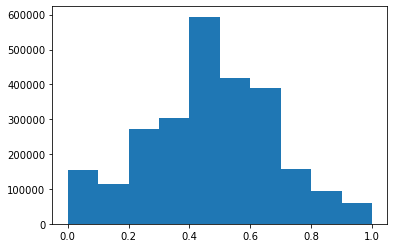

In [263]:
plt.hist(yhat_test)

In [11]:
song_df["genre_ids"].unique()

array(['465', '444', '726', ..., '786|958|2022', '1259|2107', '1138|2022'],
      dtype=object)

In [12]:
genre_unique =  song_df["genre_ids"].unique()

In [13]:
genre_dic = {}
genre_set = set()
for i in range(genre_unique.shape[0]):
    
    if genre_unique[i] is not None:
        val = genre_unique[i].split("|")
        genre_set = genre_set.union(val)
        genre_dic[genre_unique[i]] = val
        
        
    

In [14]:
len(genre_set)

191

In [15]:
song_df.shape

(2296320, 7)

In [16]:
count = 0
genre_idx = {}
for val in genre_set:
    genre_idx[val] = count
    count += 1

In [17]:
n_genre = len(genre_set)
n_genre

191

In [18]:
song_genre_mat =  np.zeros((n_song+1, n_genre), dtype =  bool)

In [19]:
genre_ids_array = song_df["genre_ids"].to_numpy(copy = True)

In [20]:
for i in range(n_song):
    val =  genre_ids_array[i]
    if val is not None:
        genre_list = genre_dic[val]

        for j in range(len(genre_list)):
            idx = genre_idx[genre_list[j]]

            song_genre_mat[i+1, idx] = True

In [21]:
song_genre_df = pd.DataFrame(song_genre_mat)

In [22]:
col_names = []
for i in range(n_genre):
    col_names.append("genre_" +  str(i))

In [23]:
song_genre_df.columns = col_names

In [24]:
song_genre_df["song_idx"] = np.arange(-1, n_song)

In [25]:
song_genre_df

,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,...,genre_182,genre_183,genre_184,genre_185,genre_186,genre_187,genre_188,genre_189,genre_190,song_idx
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,-1
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2296316,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2296315
2296317,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2296316
2296318,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2296317
2296319,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2296318


In [26]:
train_df2 = train_df[["target", "msno_idx", "song_idx"]]

In [27]:
train_df2 = train_df2.merge(song_genre_df, on =  "song_idx", how = "left")

In [30]:
def cal_prob(count_0, count_1, D = 10):
    
    val = count1/(count_0+count1 + D)
    
    return val

## Source System

In [ ]:
filter1 = train_df["source_system_tab"].isna()
train_df.loc[filter1, "source_system_tab"] =  "Z"

filter1 = test_df["source_system_tab"].isna()
test_df.loc[filter1, "source_system_tab"] =  "Z"

In [ ]:
sources = train_df["source_system_tab"].unique()
sources_dic = {}
for i in range(sources.shape[0]):
    sources_dic[sources[i]] = i

In [ ]:
train_df["sources_id"] =  train_df["source_system_tab"].apply(lambda x: sources_dic[x])
test_df["sources_id"] =  test_df["source_system_tab"].apply(lambda x: sources_dic[x])

In [ ]:
member_source_df1 = train_df[["msno_idx", "sources_id", "target"]].groupby(["msno_idx", "sources_id"]).sum()
member_source_df10 =  train_df[["msno_idx", "sources_id", "target"]].groupby(["msno_idx", "sources_id"]).count()
member_source_df = member_source_df1/(member_source_df10 + 0.5)
member_source_df = member_source_df.reset_index()
member_source_t = member_source_df.pivot_table(index = "msno_idx", columns = ["sources_id"])

In [201]:
member_source_mat = member_source_t.to_numpy()

### Validation

In [ ]:
member_genre1 = train_df2.drop(["song_idx"], axis = 1).iloc[0:int(n_train*0.9),:].query("target == 1").groupby("msno_idx").sum()
member_genre01 = train_df2.drop(["song_idx"], axis = 1).iloc[0:int(n_train*0.9),:].groupby("msno_idx").sum()
member_genre_prob = member_genre1/(member_genre01 + 5)

In [ ]:
member_genre_prob.drop(["target"], axis = 1, inplace = True)
member_genre_prob = member_genre_prob.reset_index()

In [32]:
member_genre_mat = member_genre_prob.drop(["msno_idx"], axis = 1).to_numpy()

In [ ]:
msno_idx_array2 = member_genre_prob["msno_idx"].to_numpy()

msno_idx_loc = {}
for i in range(msno_idx_array2.shape[0]):
    msno_idx_loc[msno_idx_array2[i]] = i
    

In [127]:
msno_val = train_df["msno_idx"].iloc[int(n_train*0.9):].to_numpy()
song_val = train_df["song_idx"].iloc[int(n_train*0.9):].to_numpy()
y_val = train_df["target"].iloc[int(n_train*0.9):].to_numpy()

In [134]:
n_val = y_val.shape[0]
yhat_val = np.zeros(n_val)

In [194]:
for i in range(n_val):
    try:
        yhat_val[i] = np.sum(member_genre_mat[msno_idx_loc[msno_val[i]],:][song_genre_mat[song_val[i]+1]])
    except KeyError:
        yhat_val[i] = 0.5

In [195]:
yhat_val[np.isnan(yhat_val)] = 0.5

In [197]:
yhat_val[yhat_val > 1] = 1

4205

In [198]:
plt.hist(yhat_val)

In [199]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val, pos_label=1)

(array([ 78099.,  48337.,  75950.,  97598., 111122., 157400.,  80942.,
         49646.,  25906.,  12742.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

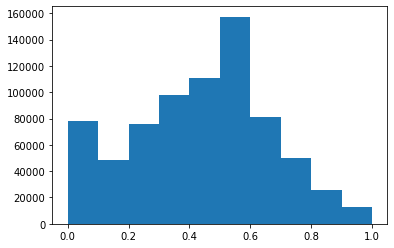

In [200]:
metrics.auc(fpr, tpr)

### Test

In [274]:
song_mean_df = train_df[["song_idx", "target"]].groupby("song_idx").mean().reset_index()
song_mean = np.zeros(n_song+1) + 0.5
song_mean[song_mean_df["song_idx"]+1] = song_mean_df["target"]

In [275]:
song_mean.shape[0], n_song

(2296321, 2296320)

In [276]:
song_source_df = train_df[["song_idx","sources_id", "target"]].groupby(["song_idx", "sources_id"]).mean().reset_index()

In [277]:
song_source_t = song_source_df.pivot_table(index = "song_idx", columns = ["sources_id"]).reset_index()

In [278]:
song_source_t

song_idx    target                                              \
sources_id                  0         1         2         3    4        5   
0                -1  0.000000  0.546875  0.315789  0.125000  NaN  0.20000   
1                 0       NaN  0.625000       NaN  0.000000  NaN      NaN   
2                 1  0.551402  0.803045  0.703125  0.503790  0.6  0.34375   
3                 2  0.454545  0.625806  0.346154  0.339806  0.0  0.00000   
4                 3       NaN  0.614634  0.282609  0.450000  0.0  0.00000   
...             ...       ...       ...       ...       ...  ...      ...   
359910      2296048       NaN       NaN       NaN  0.000000  NaN      NaN   
359911      2296161       NaN       NaN  0.000000       NaN  NaN      NaN   
359912      2296187       NaN  0.000000       NaN       NaN  NaN      NaN   
359913      2296259       NaN  0.000000       NaN       NaN  NaN      NaN   
359914      2296280       NaN  0.000000       NaN       NaN  NaN      NaN   

                               
sources_id         6    7   8  
0           0.500000  NaN NaN  
1           0.000000  NaN NaN  
2           0.090909  1.0 NaN  
3           0.166667  NaN NaN  
4           0.288889  NaN NaN  
...              ...  ...  ..  
359910           NaN  NaN NaN  
359911           NaN  NaN NaN  
359912           NaN  NaN NaN  
359913           NaN  NaN NaN  
359914           NaN  NaN NaN  

[359915 rows x 10 columns]

In [279]:
source_mean = train_df[["sources_id", "target"]].groupby("sources_id").mean()["target"].to_numpy()

In [280]:
source_mean

array([0.42214601, 0.61965897, 0.42136194, 0.41576972, 0.51036259,
       0.22266158, 0.3265808 , 0.37801132, 0.59090909])

In [281]:
song_source_mat = np.zeros((n_song+1, 9)) -1

In [282]:
song_source_mat[:,:] = source_mean[:]

In [284]:
song_source_mat2 = song_source_mat.copy()

In [285]:
song_source_mat[song_source_t["song_idx"]+1] = song_source_t["target"]

In [286]:
song_source_mat[np.isnan(song_source_mat)] = song_source_mat2[np.isnan(song_source_mat)]

In [51]:
member_genre1 = train_df2.drop(["song_idx"], axis = 1).query("target == 1").groupby("msno_idx").sum()
member_genre01 = train_df2.drop(["song_idx"], axis = 1).groupby("msno_idx").sum()
member_genre_prob = member_genre1/(member_genre01 + 0.5)

In [52]:
member_genre_prob.drop(["target"], axis = 1, inplace = True)
member_genre_prob = member_genre_prob.reset_index()

In [53]:
member_genre_mat = member_genre_prob.drop(["msno_idx"], axis = 1).to_numpy()

In [54]:
msno_idx_array2 = member_genre_prob["msno_idx"].to_numpy()

msno_idx_loc = {}
for i in range(msno_idx_array2.shape[0]):
    msno_idx_loc[msno_idx_array2[i]] = i

In [77]:
member_genre_mat.shape[0]/n_member

0.8939627358079237

In [288]:
msno_test = test_df["msno_idx"].to_numpy()
song_test = test_df["song_idx"].to_numpy()

In [289]:
source_test = test_df["sources_id"].to_numpy()

In [306]:
yhat_test = np.zeros(n_test)

In [307]:
member_source_mat.shape, member_genre_mat.shape

((30755, 9), (30755, 191))

In [308]:
count = 0
for i in range(n_test):
    divider = np.sum(song_genre_mat[song_test[i]+1])
    
    if divider > 0:
        try:
            val1 = member_source_mat[msno_idx_loc[msno_test[i]], source_test[i]]
            #val2 = np.sum(member_genre_mat[msno_idx_loc[msno_test[i]],:][song_genre_mat[song_test[i]+1]])/divider
            yhat_test[i] = val1 
            #yhat_test[i] = (val1 + val2)/2
        except KeyError:
            count += 1
            #yhat_test[i] = song_mean[song_test[i]+1]
            val3 = song_source_mat[song_test[i]+1, source_test[i]]
            
            
    else:
        
        yhat_test[i] = source_mean[source_test[i]]

(array([306250., 154584., 250163., 333811., 406554., 336694., 287937.,
        192755., 132836.,  64526.]),
 array([0.        , 0.09992759, 0.19985518, 0.29978277, 0.39971035,
        0.49963794, 0.59956553, 0.69949312, 0.79942071, 0.8993483 ,
        0.99927589]),
 <BarContainer object of 10 artists>)

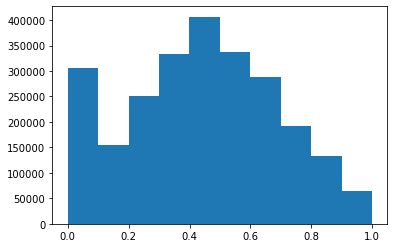

In [309]:
plt.hist(yhat_test)

In [315]:
np.sum(np.isnan(yhat_test))/n_test

0.0

In [311]:
filter1 = np.isnan(yhat_test)
yhat_test[np.isnan(yhat_test)] = source_mean[source_test[filter1]]

In [312]:
count/n_test

0.07067181896049343

In [313]:
yhat_test.max(),yhat_test.min()

(0.999275887038378, 0.0)

(array([306250., 154584., 280143., 345198., 440905., 339937., 299656.,
        192755., 132836.,  64526.]),
 array([0.        , 0.09992759, 0.19985518, 0.29978277, 0.39971035,
        0.49963794, 0.59956553, 0.69949312, 0.79942071, 0.8993483 ,
        0.99927589]),
 <BarContainer object of 10 artists>)

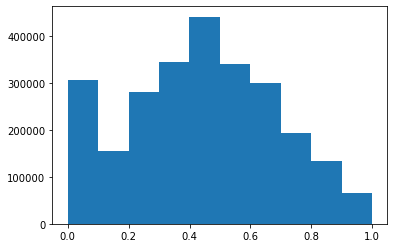

In [314]:
plt.hist(yhat_test)

In [316]:
sample_df = pd.read_parquet("data/sample_submission.parquet")

In [317]:
sample_df["target"] = yhat_test

In [318]:
sample_df.to_csv("output/Content_Source_1.csv", index = False)

In [152]:
train_df["target"].mean()

0.5035170841614234

In [156]:
train_df[["source_system_tab", "target"]].groupby("source_system_tab").mean().sort_values("target")

,target
source_system_tab,
radio,0.222662
listen with,0.326581
notification,0.378011
discover,0.415770
search,0.421362
explore,0.422146
settings,0.590909
my library,0.619659


<AxesSubplot:xlabel='source_system_tab'>

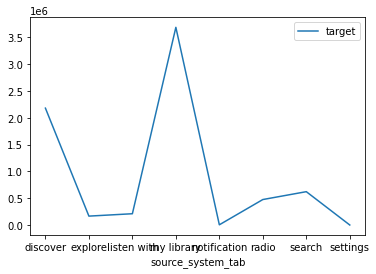

In [154]:
train_df[["source_system_tab", "target"]].groupby("source_system_tab").count().plot()

<AxesSubplot:xlabel='source_system_tab'>

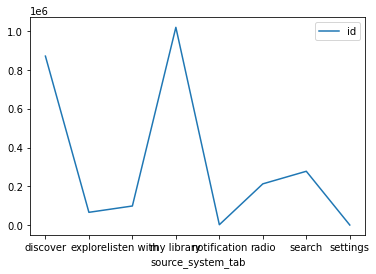

In [153]:
test_df[["source_system_tab", "id"]].groupby("source_system_tab").count().plot()

In [170]:
member_source_t

target                                                \
source_system_tab  discover   explore listen with my library notification   
msno_idx                                                                    
0                  0.095238       NaN    0.938547   0.830493          NaN   
1                  0.000000       NaN         NaN        NaN          NaN   
2                  0.580645  0.235294         NaN        NaN          NaN   
3                  0.000000       NaN         NaN        NaN          NaN   
4                  0.000000       NaN         NaN        NaN          NaN   
...                     ...       ...         ...        ...          ...   
34398              0.609062       NaN         NaN        NaN          NaN   
34399                   NaN       NaN         NaN   0.830189          NaN   
34400                   NaN       NaN         NaN   0.322581          NaN   
34401                   NaN       NaN         NaN   0.755418          NaN   
34402                   NaN       NaN         NaN   0.260870          NaN   

                                            
source_system_tab radio    search settings  
msno_idx                                    
0                   NaN  0.960000      NaN  
1                   NaN       NaN      NaN  
2                   NaN       NaN      NaN  
3                   NaN       NaN      NaN  
4                   NaN  0.000000      NaN  
...                 ...       ...      ...  
34398               NaN       NaN      NaN  
34399               NaN       NaN      NaN  
34400               NaN       NaN      NaN  
34401               NaN  0.857143      NaN  
34402               NaN       NaN      NaN  

[30647 rows x 8 columns]

In [199]:
member_source_t

target                                                         
sources_id         0         1         2         3    4   5         6   7   8
msno_idx                                                                     
0                NaN  0.830493  0.960000  0.095238  NaN NaN  0.938547 NaN NaN
1                NaN       NaN       NaN  0.000000  NaN NaN       NaN NaN NaN
2           0.235294       NaN       NaN  0.580645  NaN NaN       NaN NaN NaN
3                NaN       NaN       NaN  0.000000  NaN NaN       NaN NaN NaN
4                NaN       NaN  0.000000  0.000000  NaN NaN       NaN NaN NaN
...              ...       ...       ...       ...  ...  ..       ...  ..  ..
34398            NaN       NaN       NaN  0.609062  NaN NaN       NaN NaN NaN
34399            NaN  0.830189       NaN       NaN  0.0 NaN       NaN NaN NaN
34400            NaN  0.322581       NaN       NaN  NaN NaN       NaN NaN NaN
34401            NaN  0.755418  0.857143       NaN  NaN NaN       NaN NaN NaN
34402            NaN  0.260870       NaN       NaN  NaN NaN       NaN NaN NaN

[30755 rows x 9 columns]